[[이유한님] 캐글 코리아 캐글 스터디 커널 커리큘럼](https://kaggle-kr.tistory.com/32)  
[타이타닉 캐글 링크](https://www.kaggle.com/c/titanic)

# [Introduction to Ensembling/Stacking in Python](https://www.kaggle.com/code/arthurtok/introduction-to-ensembling-stacking-in-python)  

# Introduction
This notebook is a very basic and simple introductory primer to the method of ensembling (combining) base learning models, in particular the variant of ensembling known as Stacking. In a nutshell stacking uses as a first-level (base), the predictions of a few basic classifiers and then uses another model at the second-level to predict the output from the earlier first-level predictions.  
  
The Titanic dataset is a prime candidate for introducing this concept as many newcomers to Kaggle start out here. Furthermore even though stacking has been responsible for many a team winning Kaggle competitions there seems to be a dearth of kernels on this topic so I hope this notebook can fill somewhat of that void.  
  
I myself am quite a newcomer to the Kaggle scene as well and the first proper ensembling/stacking script that I managed to chance upon and study was one written in the AllState Severity Claims competition by the great Faron. The material in this notebook borrows heavily from Faron's script although ported to factor in ensembles of classifiers whilst his was ensembles of regressors. Anyway please check out his script here:  
  
[Stacking Starter](https://www.kaggle.com/code/mmueller/stacking-starter) : by Faron  
※ 링크가 사라져서 동일한 유저의 동명의 코드 링크 연결
  
Now onto the notebook at hand and I hope that it manages to do justice and convey the concept of ensembling in an intuitive and concise manner. My other standalone Kaggle script which implements exactly the same ensembling steps (albeit with different parameters) discussed below gives a Public LB score of 0.808 which is good enough to get to the top 9% and runs just under 4 minutes. Therefore I am pretty sure there is a lot of room to improve and add on to that script. Anyways please feel free to leave me any comments with regards to how I can improve  
  
# DeepL 번역
이 노트는 기본 학습 모델을 조합(결합)하는 방법, 특히 스태킹으로 알려진 조합의 변형에 대한 매우 기본적이고 간단한 입문서입니다. 간단히 말해 스태킹은 몇 가지 기본 분류기의 예측을 1레벨(기본)로 사용한 다음 2레벨에서 다른 모델을 사용하여 앞선 1레벨 예측의 결과를 예측하는 방식입니다.  
  
타이타닉 데이터 세트는 이 개념을 도입하기에 가장 적합한 후보입니다. 많은 Kaggle 초보자가 여기서 시작하기 때문입니다. 또한 스태킹은 많은 팀이 Kaggle 대회에서 우승하는 데 기여했음에도 불구하고 이 주제에 대한 커널이 부족한 것 같아서 이 노트북이 그 공백을 어느 정도 메울 수 있기를 바랍니다.  
  
저 역시 Kaggle을 처음 접했고, 우연히 발견하고 공부한 최초의 제대로 된 앙상블/스태킹 스크립트는 위대한 Faron이 올스테이트 심각도 주장 대회에서 작성한 것이었습니다. 이 노트의 자료는 Faron의 스크립트에서 많이 차용했지만, 분류기의 앙상블을 고려하도록 포팅된 반면, 그의 스크립트는 회귀기의 앙상블을 고려했습니다. 어쨌든 그의 스크립트는 여기에서 확인하시기 바랍니다:  
  
[스태킹 스타터](https://www.kaggle.com/code/mmueller/stacking-starter) : Faron 제공  
※ 링크가 사라져서 동일한 유저의 동명의 코드 링크 연결
  
이제 손에 들고 있는 노트북으로 넘어가서 앙상블의 개념을 직관적이고 간결하게 전달할 수 있기를 바랍니다. 아래에서 설명하는 것과 정확히 동일한 앙상블 단계를 구현하는(매개 변수는 다르지만) 다른 독립 실행형 Kaggle 스크립트는 상위 9%에 들기에 충분한 0.808의 공개 LB 점수를 제공하며 4분 미만으로 실행됩니다. 따라서 이 스크립트를 개선하고 추가할 수 있는 여지가 많다고 확신합니다. 어쨌든 개선할 수 있는 방법에 대해 의견을 남겨 주시기 바랍니다.

In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)   # 쥬피터 노트북(웹)에서 실행할 때 출력 화면에 바로 뜨게 하는 명령어
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier

from sklearn.svm import SVC
from sklearn.model_selection import KFold

# Feature Exploration, Engineering and Cleaning
Now we will proceed much like how most kernels in general are structured, and that is to first explore the data on hand, identify possible feature engineering opportunities as well as numerically encode any categorical features.

In [2]:
# Load in the train and test datasets
path = './input/001_titanic/'
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


Well it is no surprise that our task is to somehow extract the information out of the categorical variables  
  
### Feature Engineering
  
Here, credit must be extended to Sina's very comprehensive and well-thought out notebook for the feature engineering ideas so please check out his work  
  
[Titanic Best Working Classfier](https://www.kaggle.com/code/sinakhorami/titanic-best-working-classifier) : by Sina

In [3]:
full_data = [train, test]

# Some features of my own that I have added in
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# Feature that tells whether a pssenger had a cabin on the Titanic
train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize']==1, 'IsAlone'] = 1

# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

# Define function to extract tiltes from passenger names
def get_tilte(name):
    title_search = re.search(' ([A-Za-z]+\.)', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ''

# Create a new feature Title, contating the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_tilte)

# Group all non-common titles into one single grouping 'Rare'
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mile', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1}).astype(int)

    # Mapping titles
    title_mapping = {'Mr': 1, 'Misss': 2, 'Mrs': 3, 'Master': 4, 'Rare': 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

    # Mapping Fare
    dataset.loc[dataset['Fare']<=7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare']>7.91)&(dataset['Fare']<=14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare']>14.454)&(dataset['Fare']<=31), 'Fare'] = 2
    dataset.loc[dataset['Fare']>31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    # Mapping Age
    dataset.loc[dataset['Age']<=16, 'Age'] = 0
    dataset.loc[(dataset['Age']>16)&(dataset['Age']<=32), 'Age'] = 1
    dataset.loc[(dataset['Age']>32)&(dataset['Age']<=48), 'Age'] = 2
    dataset.loc[(dataset['Age']>48)&(dataset['Age']<=64), 'Age'] = 3
    dataset.loc[dataset['Age']>64, 'Age'] = 4;

In [4]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis=1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis=1)
test = test.drop(drop_elements, axis=1)

All right so now having cleaned the features and extracted relevant information and dropped the categorical columns our features should now all be numeric, a format suitable to feed into our Machine Learning models. However before we proceed let us generate some simple correlation and distribution plots of our transformed dataset to observe ho  
  
## Visualisations

In [5]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,0.0
1,1,1,0,2,0,3,1,51,1,2,0,0.0
2,1,3,0,1,0,1,0,22,0,1,1,0.0


### Pearson Correlation Heatmap
  
let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will utilise the Seaborn plotting package which allows us to plot heatmaps very conveniently as follows

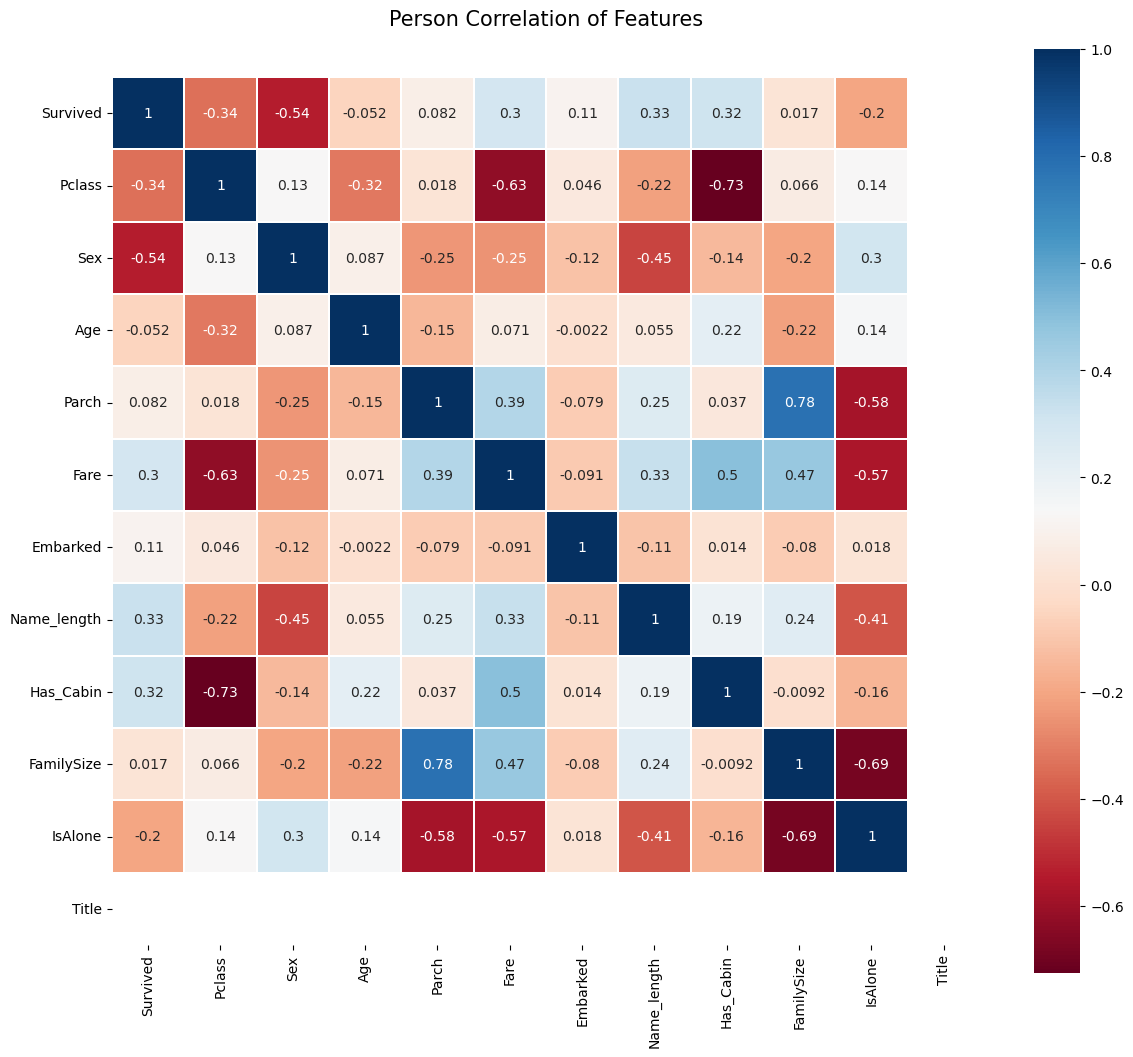

In [6]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Person Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True);

### Takeaway from the Plots
One thing that that the Pearson Correlation plot can tell us is that there are not too many features strongly correlated with one another. This is good from a point of view of feeding these features into your learning model because this means that there isn't much redundant or superfluous data in our training set and we are happy that each feature carries with it some unique information. Here are two most correlated features are that of Family size and Parch (Parents and Children). I'll still leave both features in for the purposes of this exercise.  
  
### Pairplots
Finally let us generate some pairplots to observe the distribution of data from one feature to the other. Once again we use Seaborn to help us.  
  
### DeepL 번역
피어슨 상관관계 도표에서 알 수 있는 한 가지는 서로 강한 상관관계가 있는 특징이 너무 많지 않다는 것입니다. 이는 학습 모델에 이러한 특징을 입력하는 관점에서 좋은데, 이는 학습 세트에 중복되거나 불필요한 데이터가 많지 않고 각 특징이 고유한 정보를 가지고 있다는 것을 의미하기 때문입니다. 가장 상관관계가 높은 두 가지 기능은 가족 크기와 Parch(부모와 자녀)입니다. 이 연습의 목적을 위해 두 기능을 모두 그대로 유지하겠습니다.  
  
### 페어플롯
마지막으로 한 피처에서 다른 피처로의 데이터 분포를 관찰하기 위해 몇 가지 페어플롯을 생성해 보겠습니다. 다시 한 번 Seaborn의 도움을 받겠습니다.

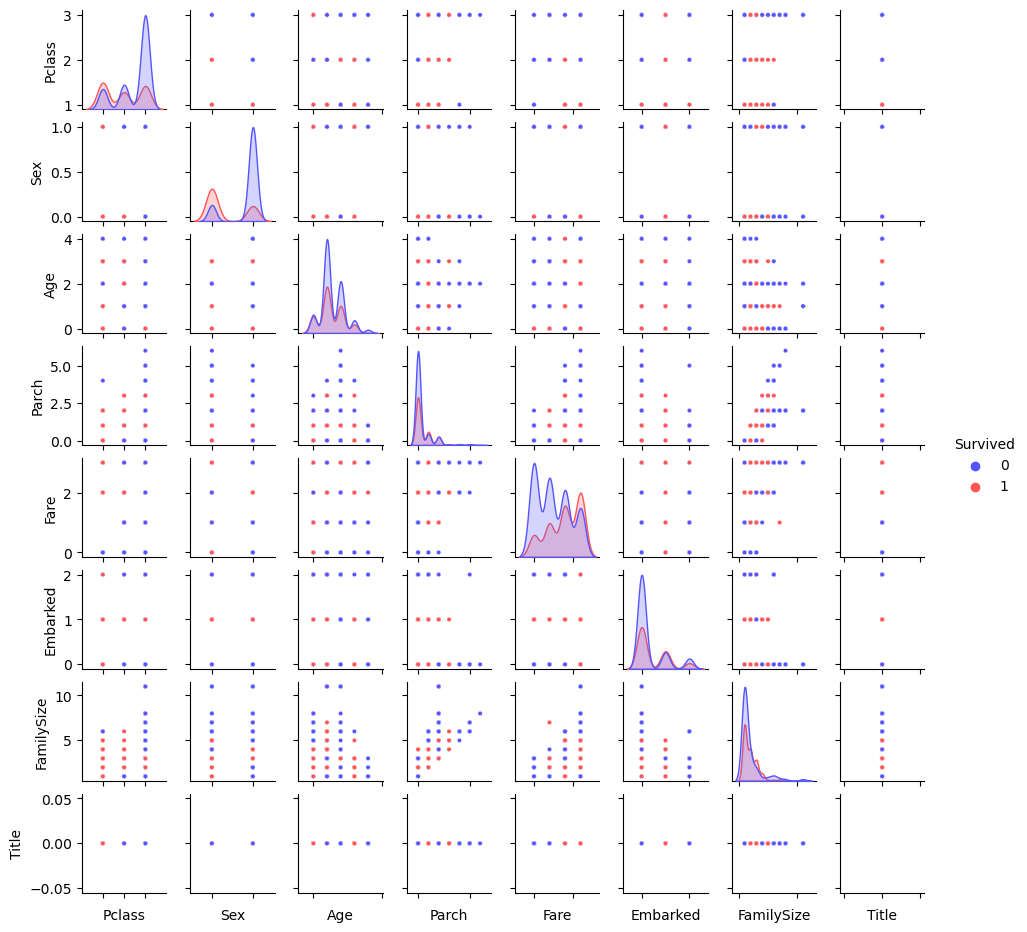

In [7]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
                        u'FamilySize', u'Title']], hue='Survived', palette='seismic', size=1.2, diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
# u-sting: 유니코드 문자열(python2에서 주로 쓰였으며 현재는 거의 불요). b-string: 바이트 문자열.
g.set(xticklabels=[]);

# Ensembling & Stacking models